## Time to Order Plot

* Generate charts for review and documentation

In [1]:
import os
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from kedro.framework.context import load_context
sys.path.append('..')
from src.lifetime_dev.TimeToOrderPlots import TimeToOrderPlots

#
# This file prints out time to second and third order plots
#
# These plots are largely informational -- they provide context about the operating
# environment in which VPLifetimes is being run.  They do not fit Lifetimes nor use it directly.
#

#
# Time to second order plots
#
project_path = Path(os.getcwd()).parents[0].resolve() 
context = load_context(project_path)
orders_df = context.catalog.load("ie_es_2010_2020")
orders_df.AGP_BUDGET_USD = orders_df.AGP_BUDGET_USD.astype('float64')
orders_df['ORDER_DATE_DT'] = pd.to_datetime(orders_df.ORDER_DATE, format='%Y-%m-%d')
model_type = 'ModifiedBetaGeoFit'

2020-08-05 19:14:04,318 - kedro.io.data_catalog - INFO - Loading data from `ie_es_2010_2020` (PickleDataSet)...


c:\users\mandersen\anaconda3\envs\py37\lib\site-packages\kedro\framework\context\context.py:538: UserWarning: Credentials not found in your Kedro project config.
No files found in ['C:\\repo\\lifetime-dev\\conf\\base', 'C:\\repo\\lifetime-dev\\conf\\local'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  str(exc)
c:\users\mandersen\anaconda3\envs\py37\lib\site-packages\fsspec\implementations\local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


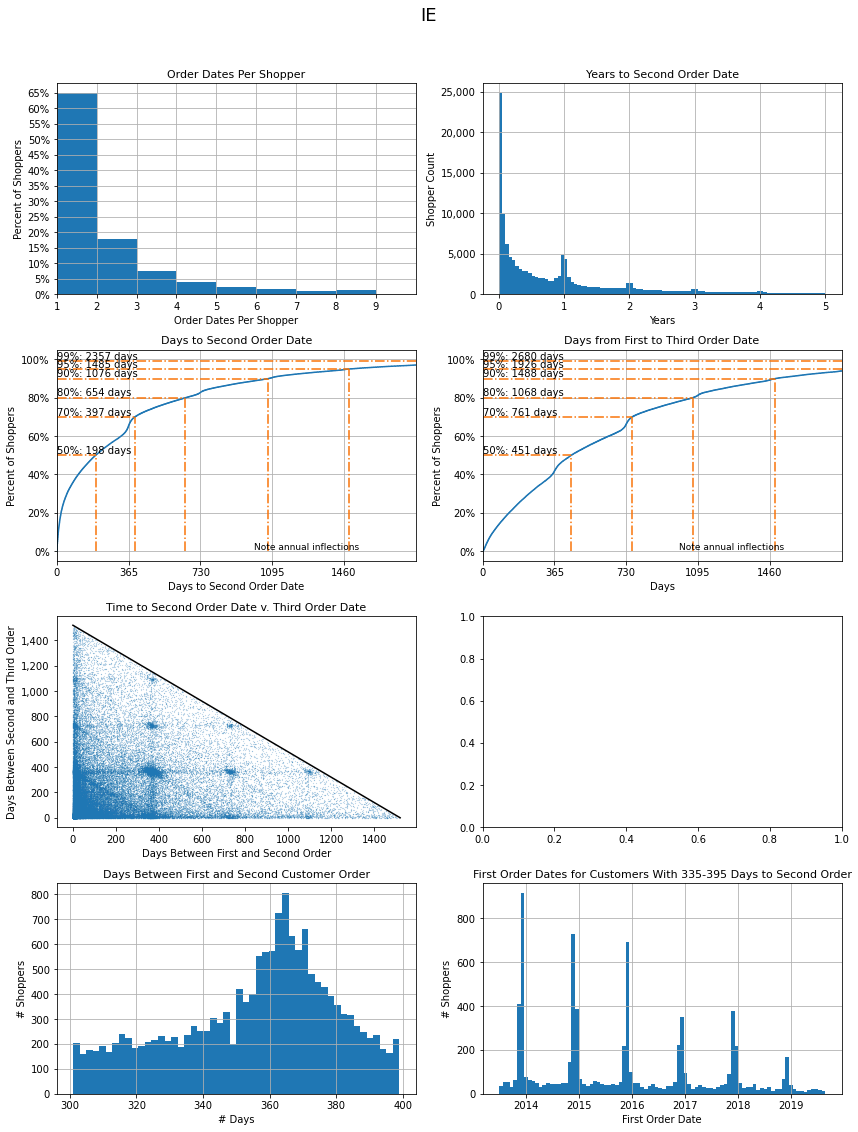

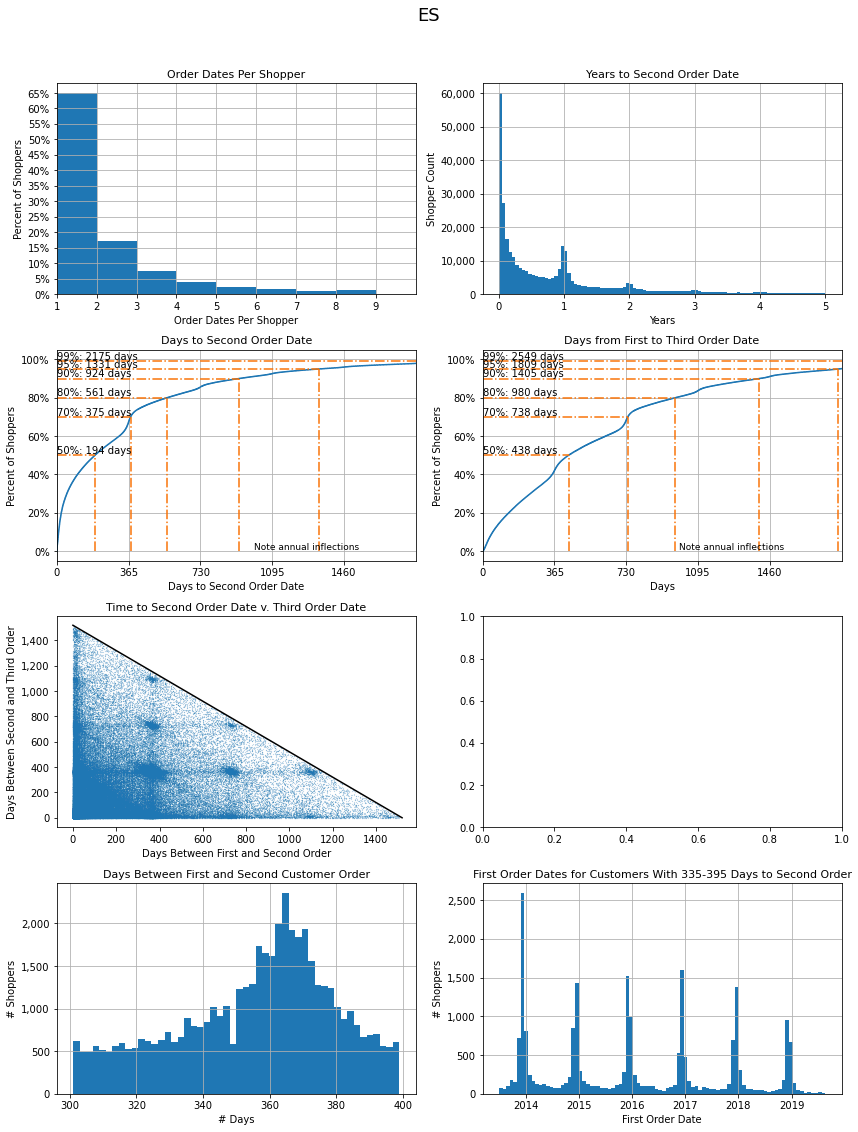

In [2]:
for country in ['IE', 'ES']:
    TimeToOrderPlots.plt_days_to_order_charts(
        orders_df[orders_df.ACCOUNT_CREATION_COUNTRY == country].copy(),
        country,
        os.path.join('..', 'docs', 'source', f'time-to-second-order-{country}.png'))


### Time to Second Order For Customers With N Orders

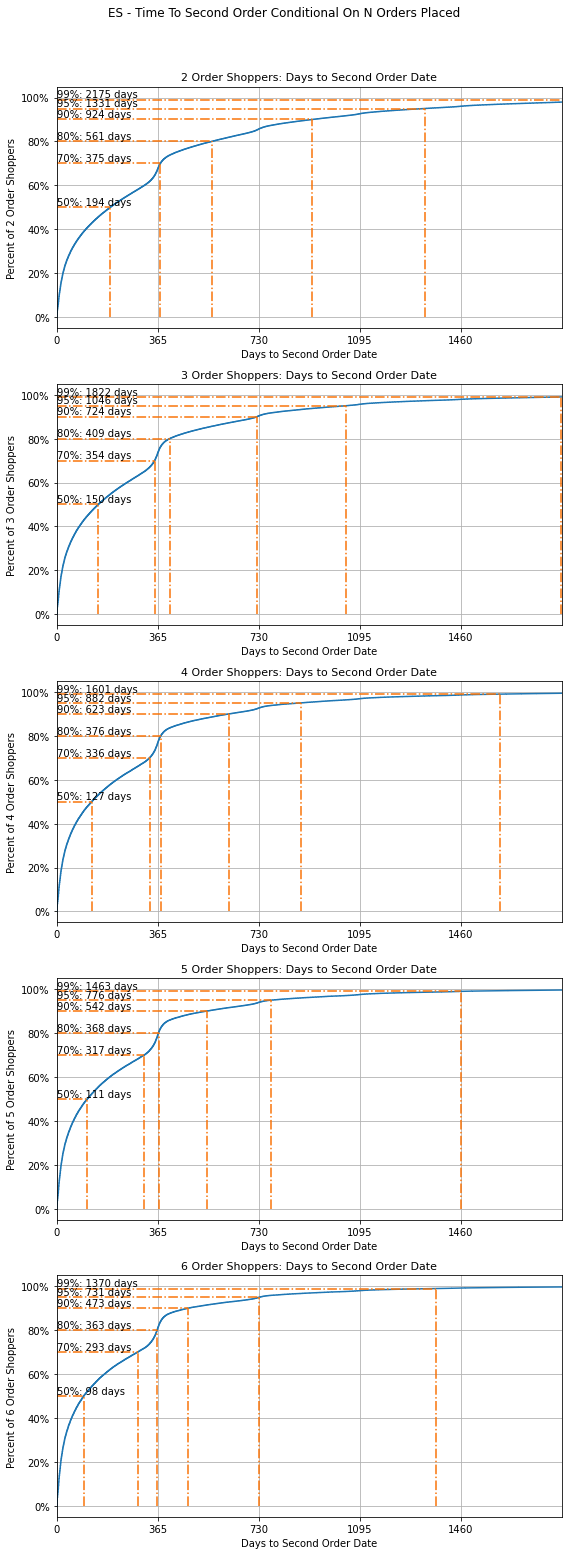

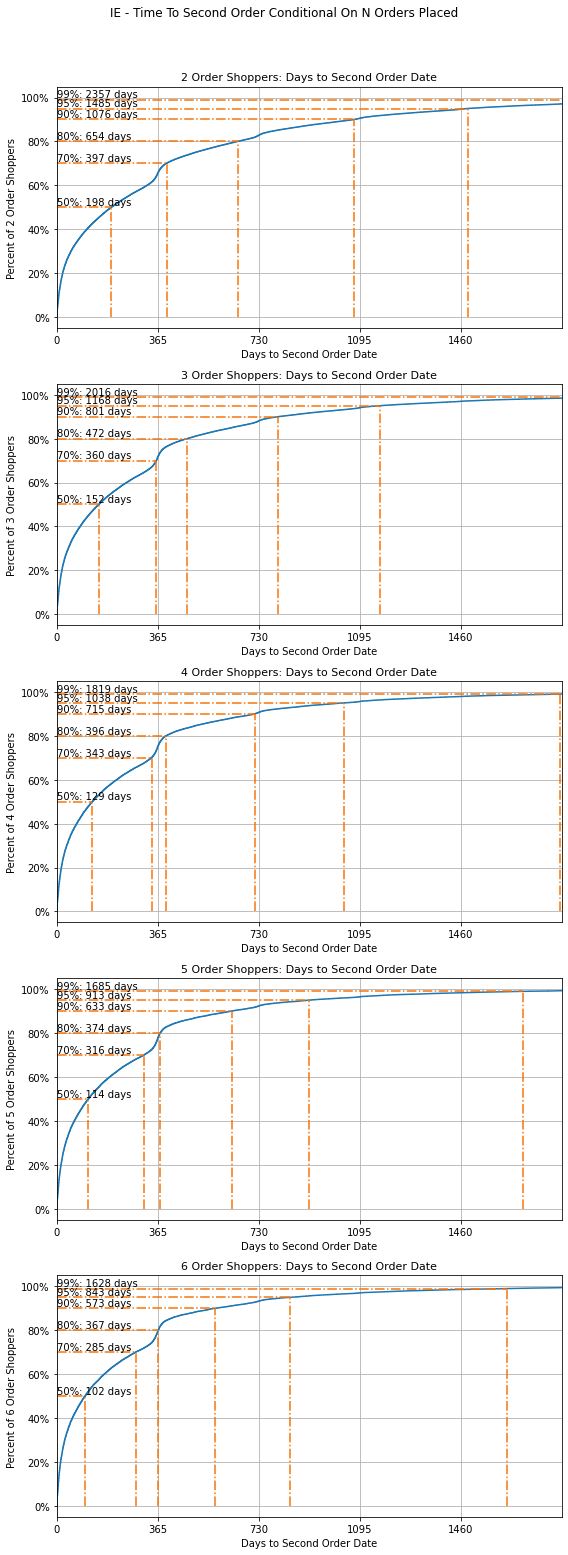

In [4]:

for country in ['ES', 'IE']:
    order_df = orders_df[orders_df.ACCOUNT_CREATION_COUNTRY == country].copy()
    min_num = 2
    max_num = 6
    fig, axes = plt.subplots(max_num - min_num + 1, figsize=(8, 22))
    fig.subplots_adjust(top=0.95)
    for order_count_num in np.arange(min_num, max_num + 1):
        ax = axes[order_count_num - min_num]
        TimeToOrderPlots.plt_days_to_nth_order(order_df,
                                               order_count_num,
                                               ax)
    plt.suptitle(f'{country} - Time To Second Order Conditional On N Orders Placed')
    plt.tight_layout(rect=(0, 0, 1, 0.96))
    filename = os.path.join('..', 'docs', 'source', f'n_order_shoppers_days_to_second_{country}.png')
    plt.savefig(filename)
    plt.show()



## Isolate holiday customers understand their time to order differently

In [10]:
order_df = orders_df[orders_df.ACCOUNT_CREATION_COUNTRY=='IE'].copy()
order_df['FIRST_ORDER_DATE_DT'] = order_df.FIRST_ORDER_DATETIME.dt.date

In [11]:
# not every customer is going to have a first order DATE in the data set due to AGP>0 restrictions
# and non-recurring etc
first_orders = order_df[order_df.ORDER_DATE == order_df.FIRST_ORDER_DATE_DT]
print(f'Number of first orders {len(first_orders)}')
print(f'Number of shoppers represented in first orders {first_orders.SHOPPER_ID.nunique()}')
print(f'Number of shoppers in original set {orders_df.SHOPPER_ID.nunique()}')

# strange that 100K shoppers do not have a first order listed.
# wonder why...

Number of first orders 371154
Number of shoppers represented in first orders 277859
Number of shoppers in original set 1289994


## Find shoppers who have no first order in the set matching their first order
* Debug and figure out if we're missing something

In [12]:
unique_shoppers = pd.DataFrame(order_df.SHOPPER_ID.unique(), columns=['SHOPPER_ID'])
unique_fo_shoppers = pd.DataFrame(first_orders.SHOPPER_ID.unique(), columns=['SHOPPER_ID'])
combined_shoppers = unique_shoppers.merge(unique_fo_shoppers, how='left', on='SHOPPER_ID', indicator=True)
combined_shoppers._merge.value_counts()

both          277859
left_only      87870
right_only         0
Name: _merge, dtype: int64

In [13]:
missing_shoppers = combined_shoppers[combined_shoppers._merge == 'left_only'].copy()
missing_shoppers.drop(columns=['_merge'], inplace=True)
missing_shoppers[:10]

SHOPPER_ID
6   TE4XUFIMIKGOSLTPM10OZTQEVO30TPW0
12  XPL403MN3RGQGQSR6QML631U7PRXTM3W
17  QIMD416V7L14SXWITFRV7PUUD5NU0FHF
22  HPEEQOD1UQO5KFPXF0KL5V2RV0NO75SZ
23  V05IG4VIM22OHO3TV3ID72JU5Q7O1GUU
25  G54DU2VOGLEWZ0KVDRSQ3DJ3IMNIVIJG
32  XT5UFQKJLM650RQ7ODJ4PDHE04END4U2
35  ETP4N44IH1HIR6JME5H3NGLG3JDT641T
36  J501M2V51W444P25TFUP34K454I65OEJ
46  U40ILKZ37S2D4SX3GZFDL13EL3G404KI

## Analysis Below: Finds that First Order Date is Not So Reliable

* There are plenty of cases where first_order_date occurs on the next day after the first order
* For analysis purposes better to treat the first order in the order set as the first order
date rather than relying on the shopper record.

In [14]:
# Order history for these missing shoppers
missing_order_history = missing_shoppers.merge(order_df, on='SHOPPER_ID', how='inner')
missing_order_history = missing_order_history.sort_values(['SHOPPER_ID', 'ORDER_DATE_DT'])
missing_order_history[:5]

SHOPPER_ID  ORDER_DATE TOTAL_BOOKINGS_USD  \
150683  0000JHID0P7K545S0PRETM2S16DFTXUX  2015-04-14          52.101210   
237375  00016QNNM7QFSJLZE6DU545D0MSP4U0L  2018-12-16          18.989950   
202967  000D2PO4S2HL2R4GFS1J3S3VP32VG3EU  2018-04-06          22.382220   
202750  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2010-09-09          49.227360   
202748  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26          21.041090   
202749  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26           4.981340   
202751  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26           8.069320   
202752  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26          11.686990   
202753  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26          40.177550   
202754  000DPDN7E10E1IDIZSOSGXIRI7XP7HD2  2011-02-26          13.388760   

        AGP_BUDGET_USD ACCOUNT_CREATION_COUNTRY    FIRST_ORDER_DATETIME  \
150683        28.90581                       IE 2015-04-15 01:09:32.107   
237375         0.14365                       IE 2018-12-17 02:31:48.983   
202967         9.99392                       IE 2018-04-07 00:31:48.830   
202750        26.76026                       IE 2010-09-10 03:15:36.607   
202748        10.46039                       IE 2010-09-10 03:15:36.607   
202749         1.91314                       IE 2010-09-10 03:15:36.607   
202751         4.67982                       IE 2010-09-10 03:15:36.607   
202752         7.45709                       IE 2010-09-10 03:15:36.607   
202753        25.83575                       IE 2010-09-10 03:15:36.607   
202754         8.95976                       IE 2010-09-10 03:15:36.607   

                      CATEGORY  \
150683                Consumer   
237375          Business Cards   
202967          Business Cards   
202750          Business Cards   
202748                 Signage   
202749          Business Cards   
202751  Packaging & Stationery   
202752  Packaging & Stationery   
202753          Business Cards   
202754  Packaging & Stationery   

                                             PRODUCT_NAME  \
150683                       Consumer Invitations - Flat    
237375  Slim Business Cards - Standard Natural Uncoate...   
202967               RSBC Business Cards EU - Horizontal    
202750                  Free Business Cards - Horizontal    
202748                           Premium Large Car Magnet   
202749         Business Card Holder - Metal - Horizontal    
202751                  Labels - Return Address - Office    
202752                          Letterhead - Office - A4    
202753                    Business Cards NA - Horizontal    
202754   Rubber Stamps - 21 x 57 mm (Large) - Horizontal    

                     CHANNEL ORDER_DATE_DT FIRST_ORDER_DATE_DT  
150683  PaidSearchNonBranded    2015-04-14          2015-04-15  
237375     PaidSearchBranded    2018-12-16          2018-12-17  
202967       OrgSearchSecure    2018-04-06          2018-04-07  
202750           RetentEmail    2010-09-09          2010-09-10  
202748      OrgSearchBranded    2011-02-26          2010-09-10  
202749      OrgSearchBranded    2011-02-26          2010-09-10  
202751      OrgSearchBranded    2011-02-26          2010-09-10  
202752      OrgSearchBranded    2011-02-26          2010-09-10  
202753      OrgSearchBranded    2011-02-26          2010-09-10  
202754      OrgSearchBranded    2011-02-26          2010-09-10

### Go Forward: Isolate First Actual Order; Call this FIRST_AGP_POS_ORDER_DT

In [15]:
# method=min needed to allow ties to come out as 1.0.  Only 1.0 is valid and there are ties
order_df['ORDER_RANK'] = order_df.groupby(['SHOPPER_ID']).ORDER_DATE_DT.rank(method='min')
agp_first = order_df[order_df.ORDER_RANK==1.0]

In [16]:
# is date in holiday range?
# month november or december
agp_first_holiday = agp_first[(agp_first.ORDER_DATE_DT.dt.month==11) | (agp_first.ORDER_DATE_DT.dt.month==12)]

### What categories seem most holiday related?

In [17]:
agp_first_holiday.CATEGORY.value_counts()

Consumer                       78363
Business Cards                 24966
Packaging & Stationery         15320
PPAG Hard Goods                 7276
PPAG Clothing & Bags            4658
Signage                         2735
Marketing Materials             1989
Other                            507
Design                           490
Packaging & Long Tail            486
PPAG                             383
Marketing Material               217
Holiday                          212
Invitations & Announcements       81
Note Cards                        70
Name: CATEGORY, dtype: int64

In [18]:
holiday_categories = ['Consumer', 'PPAG Hard Goods', 'PPAG Clothing & Bags', 'Holiday']
agp_first_holiday = agp_first_holiday[agp_first_holiday.CATEGORY.isin(holiday_categories)]
len(agp_first_holiday)

90509

In [19]:
fo_holiday_shoppers = pd.DataFrame(agp_first_holiday.SHOPPER_ID.unique(), columns=['SHOPPER_ID'])
len(fo_holiday_shoppers)

75154

## Every order gets marked for the number above

In [20]:
order_df = order_df.merge(fo_holiday_shoppers, how='left', on='SHOPPER_ID', indicator=True)
order_df['HOLIDAY_SHOPPER_FO'] = 0
order_df.loc[order_df._merge=='both', 'HOLIDAY_SHOPPER_FO'] = 1
order_df.drop(columns=['_merge'], inplace=True)
order_df.HOLIDAY_SHOPPER_FO.value_counts()

0    791301
1    195731
Name: HOLIDAY_SHOPPER_FO, dtype: int64

### Putting It All Together For Charts

* For all countries
* Use the ORDER_DATE_DT in the data rather than relying on shopper's FIRST_ORDER_DATETIME which has reliability issues and would not be consistent with this data anyway.

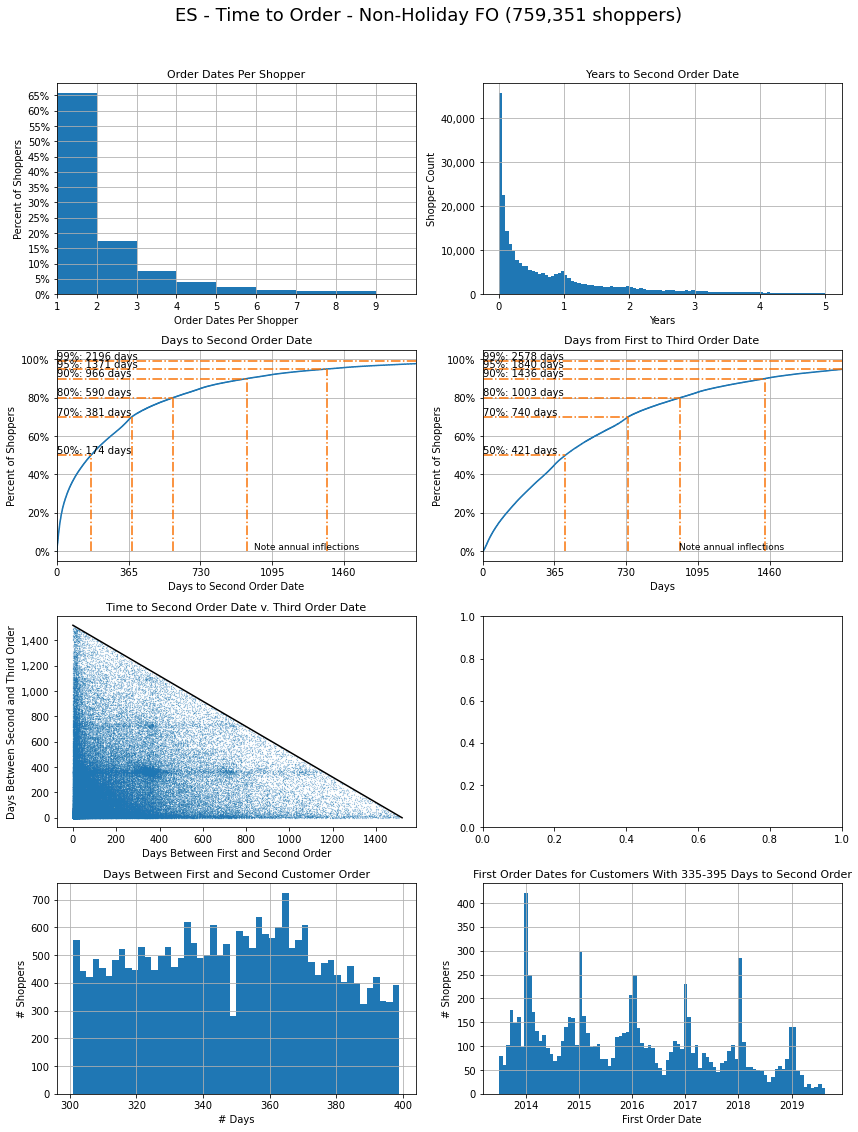

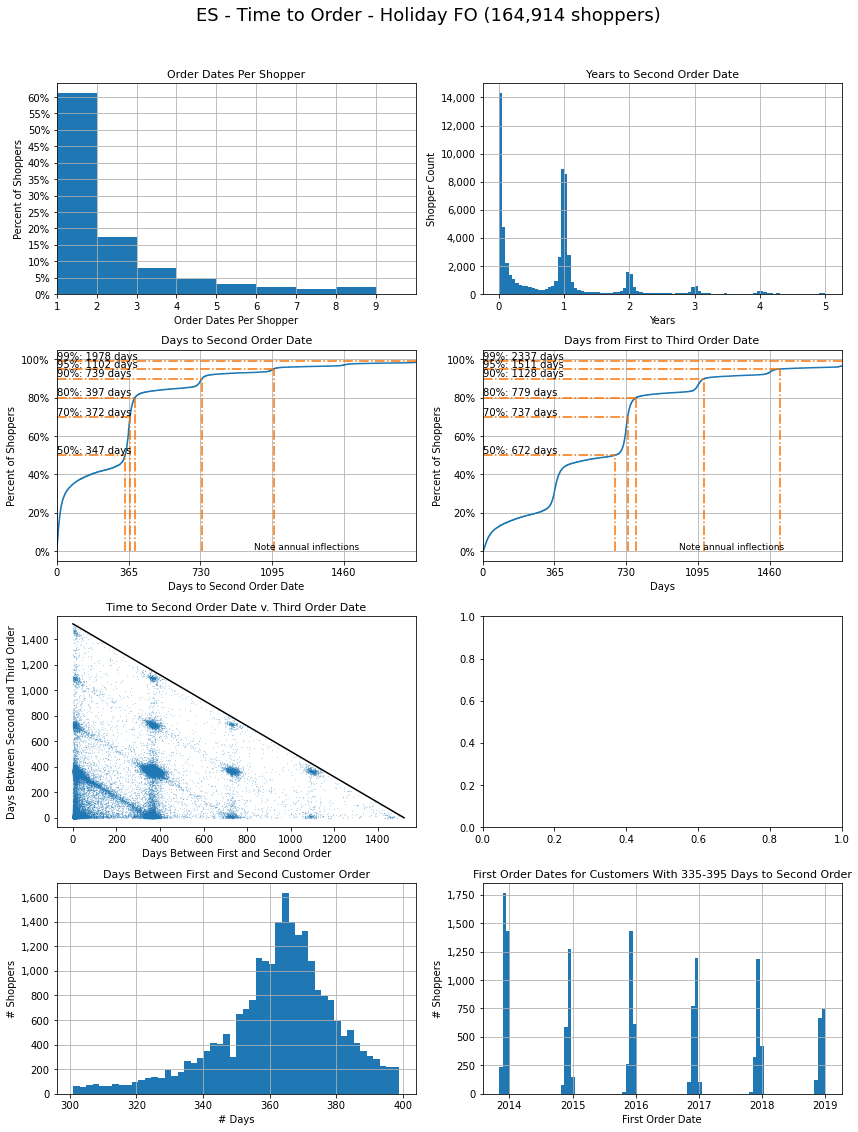

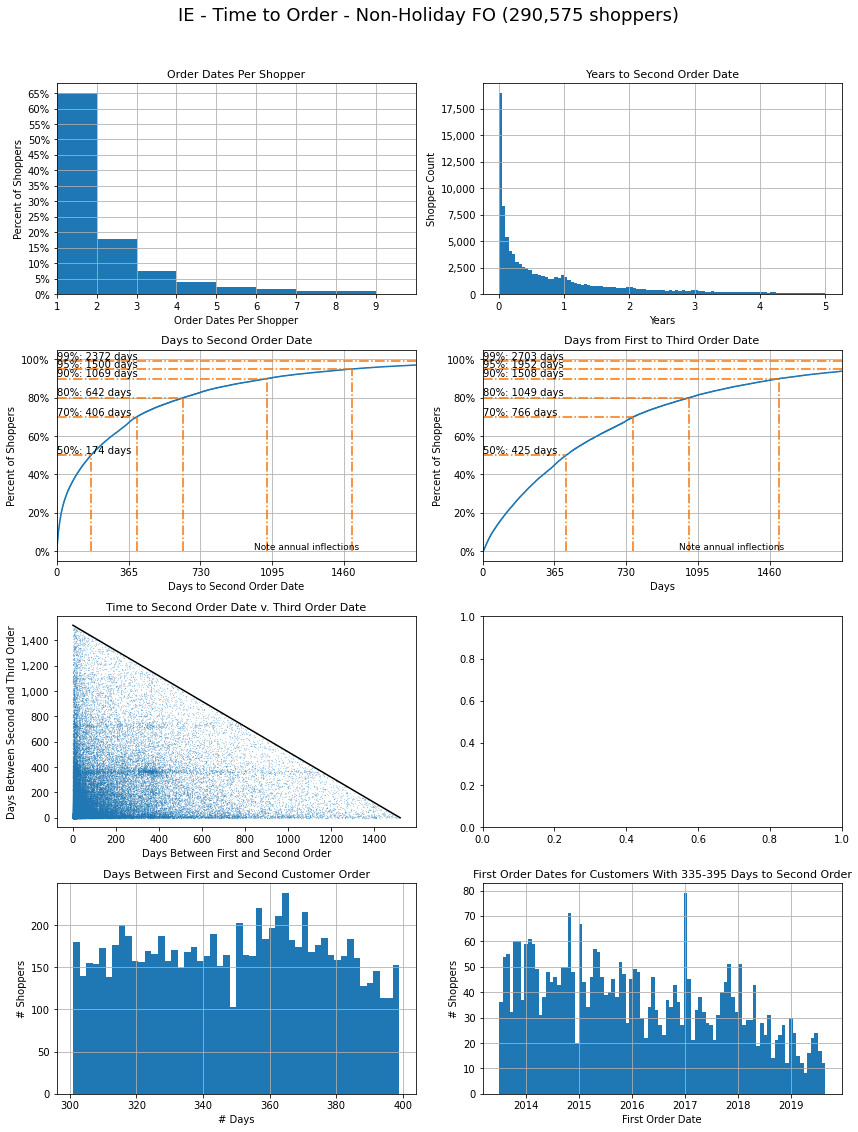

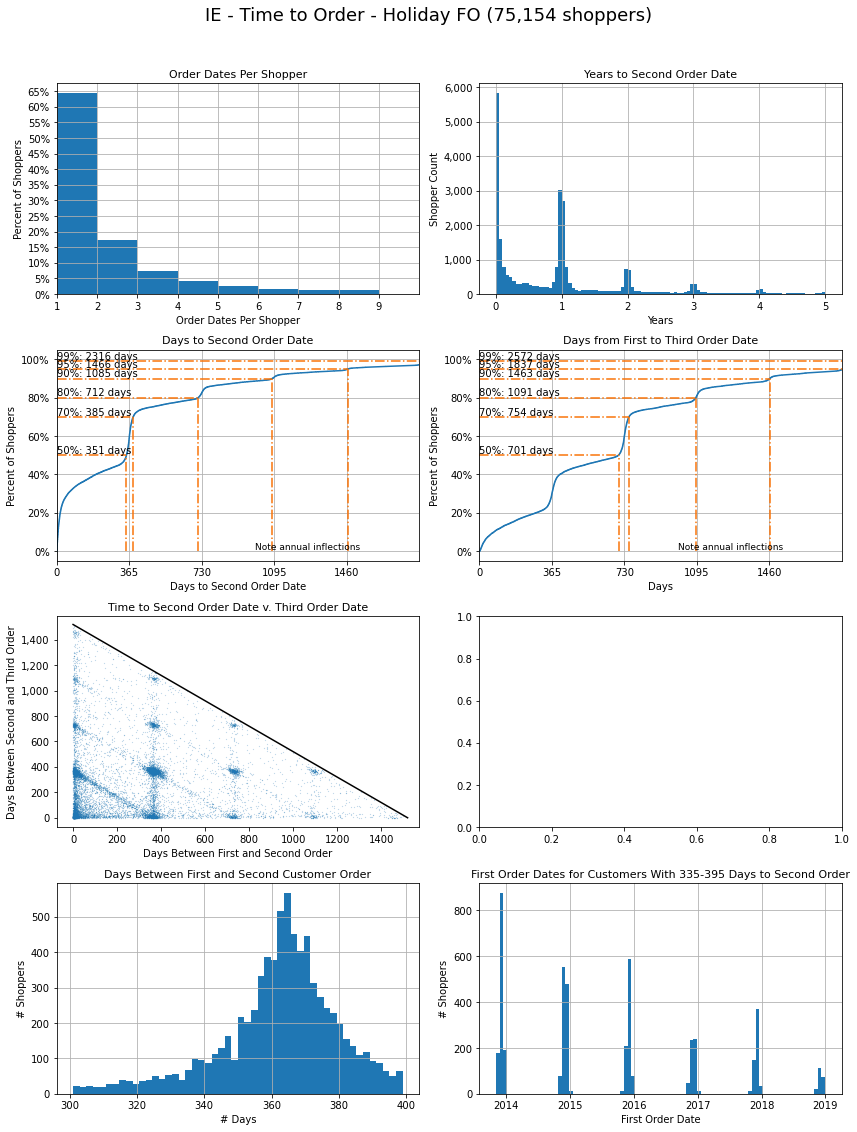

In [31]:
for country in ['ES', 'IE']:
    order_df = orders_df[orders_df.ACCOUNT_CREATION_COUNTRY==country].copy()
    #
    # Find first order in our data set (using the orders) which meet all holiday criteria
    #
    # method=min needed to allow ties to come out as 1.0.  Cannot rely on any other value
    order_df['ORDER_RANK'] = order_df.groupby(['SHOPPER_ID']).ORDER_DATE_DT.rank(method='min')
    agp_first = order_df[order_df.ORDER_RANK==1.0]
    #
    # Qualifying conditions: November and December order date
    # And also certain product categories
    agp_first_holiday = agp_first[(agp_first.ORDER_DATE_DT.dt.month==11) | (agp_first.ORDER_DATE_DT.dt.month==12)]
    holiday_categories = ['Consumer', 'PPAG Hard Goods', 'PPAG Clothing & Bags', 'Holiday']
    agp_first_holiday = agp_first_holiday[agp_first_holiday.CATEGORY.isin(holiday_categories)]
    #
    # Create marker for every FO holiday shopper and then put that in a column in order_df
    fo_holiday_shoppers = pd.DataFrame(agp_first_holiday.SHOPPER_ID.unique(), columns=['SHOPPER_ID'])
    order_df = order_df.merge(fo_holiday_shoppers, how='left', on='SHOPPER_ID', indicator=True)
    order_df['HOLIDAY_SHOPPER_FO'] = 0
    order_df.loc[order_df._merge=='both', 'HOLIDAY_SHOPPER_FO'] = 1
    order_df.drop(columns=['_merge'], inplace=True)

    #
    # Plot two subplots: one for holiday_shopper_fo 0 and the other for 1
    #
    for holiday_shopper_fo in [0, 1]:
        df = order_df[order_df.HOLIDAY_SHOPPER_FO == holiday_shopper_fo]
        unique_shoppers = df.SHOPPER_ID.nunique()
        if holiday_shopper_fo == 0:
            holiday_string = 'Non-Holiday'
        elif holiday_shopper_fo == 1:
            holiday_string = 'Holiday'
        else:
            assert False, 'Coding Error'
        suptitle = f'{country} - Time to Order - {holiday_string} FO ({"{:0,.0f}".format(unique_shoppers)} shoppers)'
        filename = f'time-to-second-order-{country}-{holiday_string}.png'
        TimeToOrderPlots.plt_days_to_order_charts(
            df,
            suptitle,
            filename=os.path.join('..', 'docs', 'source', filename))
